In [1]:
import logging
import os
import sys

import torch
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import graphviz
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def normal_variables_from_dict(d, variance):
    var_dict = {}
    for key in d.keys():
        var_dict[key] = pyro.sample(key, dist.Normal(d[key], variance))
    return var_dict

def name_to_index(name_list):
    d = {}
    for name in name_list:
        if name not in d.keys():
            d[name] = len(d.keys())
    return d

# obs_list[i] are observations corresponding to sample_list[i] and drug_list[i]
def model(sample_list, drug_list, obs_list):
    num_observations = len(obs_list)
    assert len(sample_list) == num_observations
    assert len(drug_list) == num_observations
    # get dictionaries
    samples = name_to_index(sample_list)
    drugs = name_to_index(drug_list)
    # create sample variables
    for s in pyro.plate("samples", len(samples)):
        pyro.sample(samples[s], dist.Normal(0, 1))
    # create drug variables
    for d in pyro.plate("drugs", len(drugs)):
        pyro.sample(drugs[d], dist.Normal(0, 1))
    # create observations plate
    for i in pyro.plate("data", len(obs_list)):
        sample_name = sample_list[i]
        drug_name = drug_list[i]
        name = sample_name + '_' + drug_name
        mean = pyro.sample(sample_name) * pyro.sample(drug_name)
        pyro.sample(name, dist.Normal(mean, sigma), obs=obs_list[i])
    
    # create variable for each (sample, drug) pair observed
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)
    # plate of samples
    for s in pyro.plate("samples", num_observations):
        pyro.sample(name, dist.Normal(0, 1))
    # plate of drugs
    for i in pyro.plate("data", num_observations):
        name = sample_list[i] + '_' + drug_list[i]
        mean = samples[sample_list[i]] * drugs[drug_list[i]]
        pyro.sample(name, dist.Normal(mean, sigma), obs=obs_list[i])
        
# given dataframe with columns 'sample', 'drug', and 'log(V_V0)_obs', return lists to pass to model
def format_for_model(d, vol_name):
    sample_list = list(d['sample'])
    drug_list = list(d['drug'])
    obs_list = []
    for obs in d[vol_name]:
        obs_list.append(torch.Tensor(obs))
    return sample_list, drug_list, obs_list

def get_means(var_list):
    means = {}
    for v in var_list:
        means[v] = 0
    return means

In [ ]:
def model():
    a = pyro.sample("a", dist.Normal(0, 1))
    b = pyro.sample("b", dist.Normal(a, 1))
    
def model1():
    with pyro.plate("s_plate", 4):
        s = pyro.sample("s", dist.Normal(torch.zeros(4), 1))
    with pyro.plate("d_plate", 4):
        d = pyro.sample("d", dist.Normal(torch.zeros(4), 1))
    with pyro.plate("obs_plate", 4):
        obs = pyro.sample("obs", dist.Normal(s * d, 1))
        
def model2():
    with pyro.plate("s_plate", 4):
        s = pyro.sample("s", dist.Normal(torch.zeros(4), 1))
    with pyro.plate("d_plate", 4):
        d = pyro.sample("d", dist.Normal(torch.zeros(4), 1))
    for i in pyro.plate("data", num_observations):
        name = s[i] + '_' + d[i]
        mean = s[i] * d[i]
        pyro.sample(name, dist.Normal(mean, sigma), obs=obs_list[i])
    
pyro.render_model(model1)

In [69]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [70]:
read_fn = '../results/2023-06-05/clean_and_split_data/split/train.pkl'

In [72]:
df = pd.read_pickle(read_fn)
df.head()

,sample,drug,log(V_V0)_obs,MID_list
0,HCI-019,Docetaxel,"[-4.942608336111663, -1.1067596571631226, -0.4...","[39, 40, 41]"
1,HCI-010,Navitoclax,"[0.4929405643445782, -0.1023920347984158, -0.2...","[0, 1, 2]"
2,HCI-001,Birinapant,"[3.1268442128828946, 3.367731160065172, 2.9592...","[109, 110, 111, 112, 113]"
3,HCI-023,Vehicle,"[1.4974996594708163, 1.42052797190589, 0.92956...","[164, 165, 166, 167, 168]"
4,HCI-016,Vehicle,"[1.0749322060874602, 1.9593876186593693, 1.702...","[51, 52, 53, 54, 55, 56]"


In [ ]:
# convert (sample, drug, logV) into sample_indices, drug_indices, observations
# sample --> dict: sample-name --> idx
# drug --> dict: drug-name --> idx
# one_hot_encoding(sample, name_to_idx)
# one_hot_encoding(drug, name_to_idx)

def get_observations(vecs):
    observations = []
    for vec in vecs:
        observations.append(torch.Tensor(vec))
    return observations

def name_to_idx(elems):
    d = {}
    for elem in elems:
        if elem not in d.keys():
            d[elem] = len(d.keys())
    return d

def one_hot_encoding(elem_list, elem_dict):
    num_elems = len(elem_dict.keys())
    num_obs = len(elem_list)
    encoding = torch.zeros((num_elems, num_obs))
    for j in range(0, num_obs):
        idx = elem_dict[elem_list[i]]
        encoding[idx, j] = 1
    return encoding

def format_for_model(df):
    samples = list(df['sample'])
    drugs = list(df['drug'])
    observations = get_observations(list(df['log(V_V0)_obs']))
    sample_dict = name_to_idx(samples)
    drug_dict = name_to_idx(drugs)
    sample_indices = one_hot_encoding(samples, sample_dict)
    drug_indices = one_hot_encoding(drugs, drug_dict)
    return sample_indices, drug_indices, observations

In [ ]:
sample_indices = torch.transpose(torch.Tensor(np.array([[1, 0, 0, 0], [0, 1, 0, 0]])), 0, 1)
drug_indices = torch.transpose(torch.Tensor(np.array([[0, 0, 1, 0, 0], [0, 0, 0, 1, 0]])), 0, 1)
tensor1 = torch.Tensor(np.array([1, 2]))
tensor2 = torch.Tensor(np.array([4, 5, 6]))
observations = [tensor1, tensor2]

[tensor([1., 2.]), tensor([4., 5., 6.])]
tensor([1., 2.])
tensor([4., 5., 6.])


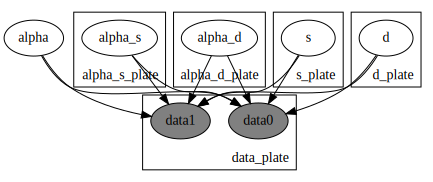

In [68]:
# observations: a list of pytorch tensor
# sample_indices: (num samples) x (num observations) matrix. Column i is a one-hot encoding of the sample index
# corresponding to observations[i]
# drug_indices: (num drugs) x (num observations) matrix. Column i is a one-hot encoding of the drug index
# corresponding to observations[i]
        
def model(sample_indices, drug_indices, observations):
    num_samples = sample_indices.shape[0]
    num_drugs = drug_indices.shape[0]
    num_observations = len(observations)
    assert num_observations == sample_indices.shape[1]
    assert num_observations == drug_indices.shape[1]
    # create global alpha
    alpha = pyro.sample("alpha", dist.Normal(0, 1))
    # create sample- and drug-specific alphas
    with pyro.plate("alpha_s_plate", num_samples):
        alpha_s = pyro.sample("alpha_s", dist.Normal(torch.zeros(num_samples), 1))
    with pyro.plate("alpha_d_plate", num_drugs):
        alpha_d = pyro.sample("alpha_d", dist.Normal(torch.zeros(num_drugs), 1))
    # variance for sample plate
    with pyro.plate("s_var_plate", num_samples):
        s_var = pyro.param("s_var", dist.Normal(torch.ones(num_samples) * 10, torch.ones(num_samples) * 5))
    # create sample plate
    with pyro.plate("s_plate", num_samples):
        s = pyro.sample("s", dist.Normal(torch.zeros(num_samples), s_var))
    # variance for drug plate
    with pyro.plate("d_var_plate", num_drugs):
        d_var = pyro.param("d_var", dist.Normal(torch.ones(num_drugs) * 10, torch.ones(num_drugs) * 5))
    # create drug plate
    with pyro.plate("d_plate", num_drugs):
        d = pyro.sample("d", dist.Normal(torch.zeros(num_drugs), 1))
    mean = torch.matmul(s, sample_indices) * torch.matmul(d, drug_indices)
    offset = alpha + torch.matmul(alpha_s, sample_indices) + torch.matmul(alpha_d, drug_indices)
    for i in pyro.plate("data_plate", 2):
        print(observations[i])
        pyro.sample("data" + str(i), dist.Normal(mean[i] + offset[i], 1), obs=observations[i])

pyro.render_model(model, model_args=(sample_indices, drug_indices, observations))

In [19]:
df = pd.read_pickle(read_fn)
df.head()

,sample,drug,log(V_V0)_obs,MID_list
0,HCI-019,Docetaxel,"[-4.942608336111663, -1.1067596571631226, -0.4...","[39, 40, 41]"
1,HCI-010,Navitoclax,"[0.4929405643445782, -0.1023920347984158, -0.2...","[0, 1, 2]"
2,HCI-001,Birinapant,"[3.1268442128828946, 3.367731160065172, 2.9592...","[109, 110, 111, 112, 113]"
3,HCI-023,Vehicle,"[1.4974996594708163, 1.42052797190589, 0.92956...","[164, 165, 166, 167, 168]"
4,HCI-016,Vehicle,"[1.0749322060874602, 1.9593876186593693, 1.702...","[51, 52, 53, 54, 55, 56]"


In [ ]:
# Set matplotlib settings
plt.style.use('default')

df = pd.read_pickle(read_fn)
vol_name = 'log(V_V0)_obs'
sample_means = get_means(df['sample'].unique())
drug_means = get_means(df['drug'].unique())
sample_list, drug_list, obs_list = format_for_model(df, vol_name)
pyro.render_model(model, 
	model_args=(sample_list, drug_list, obs_list, sample_means, drug_means), 
	render_distributions=True)